In [62]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
# %matplotlib inline

In [63]:
function_select = 3

def myfun(x):
    functions = {
        1: np.power(x,2), # quadratic function
        2: np.sin(x), # sinus
        3: np.sign(x), # signum
        4: np.exp(x), # exponential function
        5: (np.power(x,3)+ np.power(x-10,4))/np.power(x-20,2), # polynom
        6: 1+np.power(x,2)/4000-np.cos(x) # Griewank function
        # for Griewank, we need more than 50, does not generalize well (we must make sure not to have more parameters than samples in order to avoid overfitting)
    }
    return functions.get(function_select)

myfun(10)

1

In [64]:
# Generate training data.
batch_size = 32
x_train_fix = np.linspace(-1, 7, num=batch_size).reshape(-1,1)

# Generate the evaluation data. 
# (exceeds the range of the training data to evaluate the prediction capabilities)
x_eval_fix = np.linspace(-3, 10, num=batch_size).reshape(-1,1)


In [65]:
# activation_function = nn.Softmax()
activation_function = nn.Tanh()
# activation_function = nn.Tanh()
# activation_function = nn.ReLU()

# generate weights and biases for the two layers
def train_model_simple(x_train, y_train, x_eval, units, epochs):
    x_train_tensor = torch.from_numpy(x_train).float()
    y_train_tensor = torch.from_numpy(y_train).float()
    x_eval_tensor = torch.from_numpy(x_eval).float()
       
    # predefined linear layers, parameters are input and output neurons
    layer1 = nn.Linear(x_train.shape[1], units)
    layer2 = nn.Linear(units, 1, bias=False) # do not use bias on second layer
    
    # gather parameters of both layers
    parameters = list(layer1.parameters()) + list(layer2.parameters())
    
    # Adam and MSE Loss
    optimizer = optim.Adam(parameters)
    loss_fn = nn.MSELoss(reduction='mean')
    
    # main loop    
    for epoch in range(epochs):
        yhat = layer2(activation_function(layer1(x_train_tensor)))
            
        loss = loss_fn(yhat, y_train_tensor)
        
        # compute gradients
        loss.backward() 
        
        # carry out one optimization step with Adam
        optimizer.step()
        
        # reset gradients to zero
        optimizer.zero_grad()

    yhat_eval = layer2(activation_function(layer1(x_eval_tensor)))       
    # return yhat as numpy array, in the 1D-case, convert back to 1D
    #if x_train.shape[1] == 1:
    #    return yhat[:,0].detach().numpy(), yhat_eval[:,0].detach().numpy()
    #else:
    return yhat.detach().cpu().numpy(), yhat_eval.detach().cpu().numpy()

In [66]:
def approx_1d_function(x_train, x_eval, units, epochs): 
    # Generate labels for training data (here: the image of the selected function applied to X_train)
    y_train = myfun(x_train)
    
    # Scale the train data (x), the evaluation data (x_eval) and the labels (y) to the range [-1, 1].
    x_scaler = MinMaxScaler(feature_range=(-1, 1))
    y_scaler = MinMaxScaler(feature_range=(-1, 1))
    x_scaled = x_scaler.fit_transform(x_train_fix)
    y_scaled = y_scaler.fit_transform(y_train)
    x_eval_scaled = x_scaler.transform(x_eval_fix)
    
    # Build and apply multilayer perceptron.    
    _, result_eval = train_model_simple(x_scaled, y_scaled, x_eval_scaled, units, epochs)

    # Rescale the result to original range.
    res_rescaled = y_scaler.inverse_transform(result_eval)
    
    # Calculate the label (function value) for the evaluation training set.
    y_eval = myfun(x_eval)
    
    return x_eval, res_rescaled, y_eval

In [67]:
def plot_1d_function(x_train, x_eval, predictions, labels, units, epochs):
    fig = plt.figure(1, figsize=(18,6))
    ax = fig.add_subplot(1, 2, 1)
    ax.axvspan(x_train.flatten()[0], x_train.flatten()[-1], alpha=0.15, color='limegreen')
    plt.plot(x_eval, myfun(x_eval), '-', color='royalblue', linewidth=1.0)
    plt.plot(x_eval, predictions, '-', label='output', color='darkorange', linewidth=2.0)
    plt.plot(x_train, myfun(x_train), '.', color='royalblue')
    plt.grid(which='both');
    plt.rcParams.update({'font.size': 14})
    plt.xlabel('x');
    plt.ylabel('y')
    plt.title('%d neurons in hidden layer with %d epochs of training' % (units ,epochs))
    plt.legend(['Function f(x)', 'MLP output g(x)', 'Training set'])
    ax = fig.add_subplot(1, 2, 2)
    ax.axvspan(x_train.flatten()[0], x_train.flatten()[-1], alpha=0.15, color='limegreen')
    plt.plot(x_eval, np.abs(predictions-myfun(x_eval)), '-', label='output', color='firebrick', linewidth=2.0)
    plt.grid(which='both');
    plt.xlabel('x');
    plt.ylabel('y')
    plt.title('Absolute difference between prediction and actual function')
    plt.legend(['Error |f(x)-g(x)|'])
    #plt.savefig('KerasMLP_%d_neurons.pdf' % units, bbox_inches='tight')
    plt.show()

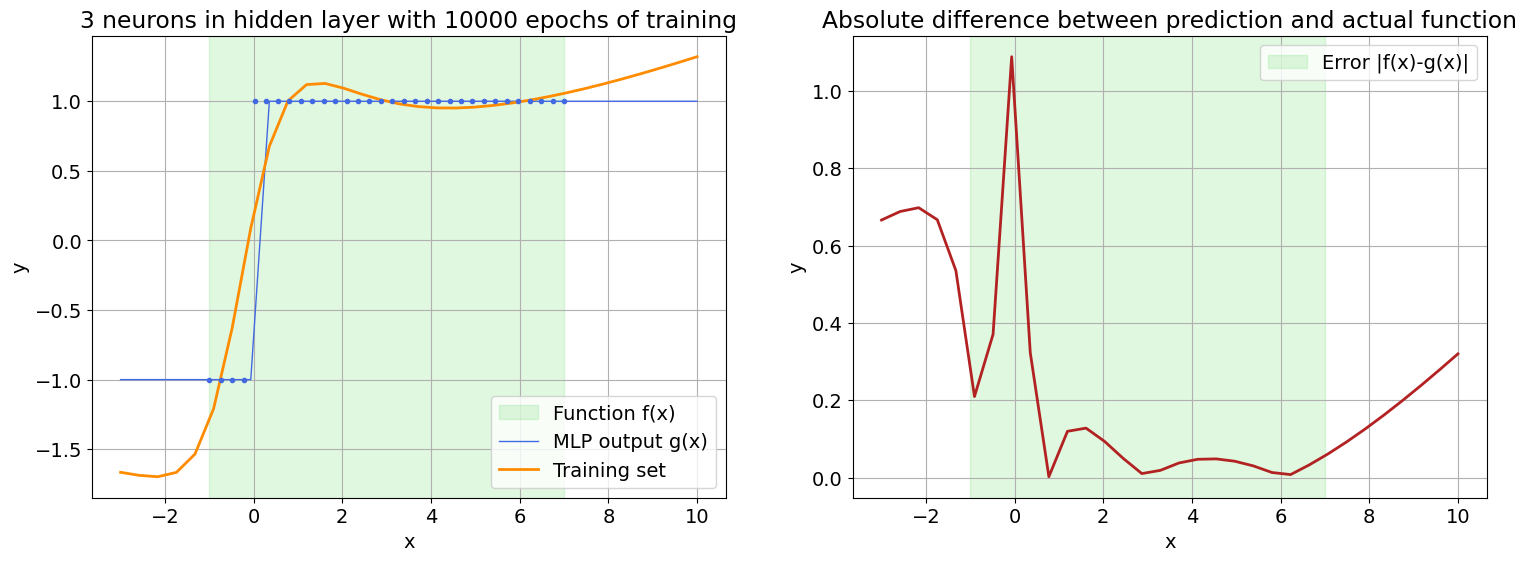

In [68]:
units = 3
epochs = 10000
x, predictions, labels = approx_1d_function(x_train=x_train_fix, x_eval=x_eval_fix, units=units, epochs=epochs)
plot_1d_function(x_train_fix, x_eval_fix, predictions, labels, units, epochs)